# Data Preprocessing

In [55]:
# Prepare input data
import ast
import pandas as pd
import numpy as np
from math import isnan
from collections import Counter
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import box
from sklearn.model_selection import train_test_split
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
import contextily


# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

# Import only first 1000 lines for testing
df = pd.read_csv('./data/sensor_readings_timeseries_part2.csv', nrows=500, parse_dates=["Timestamp"])
df = df.drop(
    ["Metadata.Location.type", "Metadata.SensorCommunitySensorType", "Metadata.SensorType", "_id"], axis=1)

# Convert string coordinates to list
df["Metadata.Location.coordinates"] = df["Metadata.Location.coordinates"].apply(
    lambda x: ast.literal_eval(x))

# no preprocessing needed
sensor_community_df = df.loc[df["Metadata.Provider"] == "sensor.community"].drop(
    ["Metadata.Provider", "Metadata.NetatmoSensorId"], axis=1)

# need to combine multiple entries for the same sensor id and time
netatmo_df = df.loc[df["Metadata.Provider"] == "netatmo"].drop(
    ["Metadata.Provider"], axis=1)

# get unique groups
grouped = netatmo_df.groupby(
    ["Metadata.NetatmoSensorId", "Timestamp"]).aggregate(list)

combined_rows = []
for label, group in grouped.iterrows():
    humidity = next((x for x in group.values[0] if not isnan(x)), np.NaN)
    pressure = next((x for x in group.values[2] if not isnan(x)), np.NaN)
    temperature = next((x for x in group.values[3] if not isnan(x)), np.NaN)

    # Humidity, Metadata.Location.coordinates, Pressure, Temperature, Timestamp
    entry = [humidity, group.values[1][0], pressure, temperature, label[1]]
    combined_rows.append(entry)

netatmo_df = pd.DataFrame(combined_rows, columns=[
                          "Humidity", "Metadata.Location.coordinates", "Pressure", "Temperature", "Timestamp"])

# Combine prepared data
prep = pd.concat([sensor_community_df, netatmo_df], ignore_index=True, axis=0)
prep = prep[prep["Temperature"].notna()]

coordinates = prep["Metadata.Location.coordinates"]

# TODO: try out WGS84
proj_wgs = 4326

geo_df = GeoDataFrame(prep[["Humidity", "Pressure", "Temperature", "Timestamp"]],
                          geometry=prep["Metadata.Location.coordinates"].apply(lambda row: Point(row[0], row[1])), crs=proj_wgs)

# Outlier detection
# TODO: remove outliers if temp too high (humidty)
# DWD as reference

# Evaluation -> show original vs cleaned data, quality steps


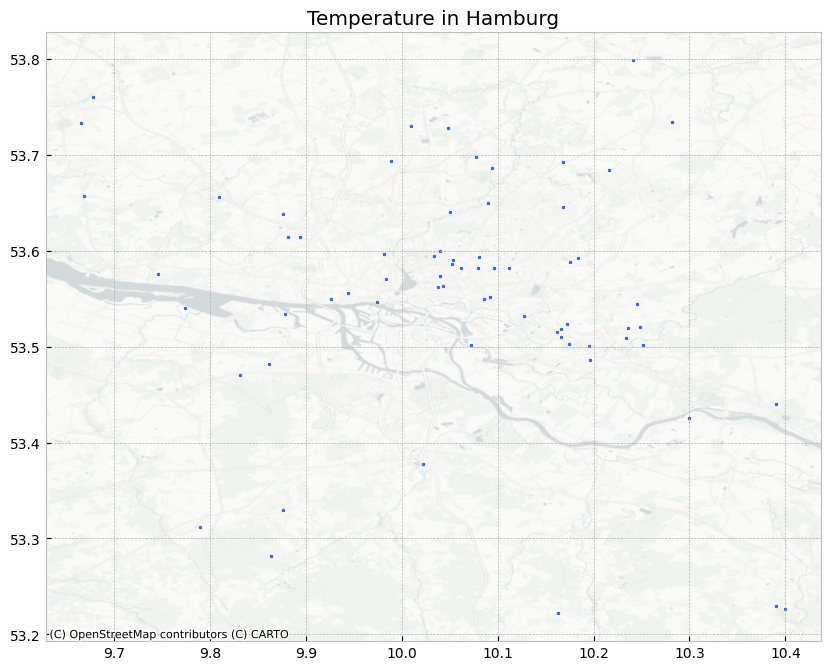

In [56]:
# Plot data
from geopandas.tools import sjoin

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('bmh')

geo_df.plot(ax=ax, marker='o', color='royalblue', markersize=3)

ax.set_title('Temperature in Hamburg')

# Add basemap
contextily.add_basemap(
    ax,
    crs=proj_wgs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)


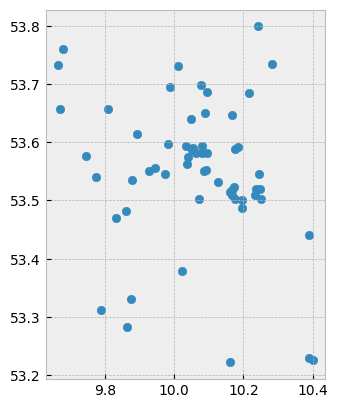

In [57]:
# Create test dataset
from pytz import UTC

start_time = pd.to_datetime('2023-02-02T20:00:00.000000000').tz_localize(UTC)
end_time = pd.to_datetime('2023-02-02T20:05:00.000000000').tz_localize(UTC)
filtered_gdf = geo_df.loc[(geo_df['Timestamp'] >= start_time)
                          & (geo_df['Timestamp'] <= end_time)]

filtered_gdf.plot()

def to_numpy_list(geo_series):
    return [[point.x, point.y]
            for point in geo_series.to_numpy()]

def geo_df_to_train_test_sets(gdf: gpd.GeoDataFrame, target_feature: str = 'Temperature') :
    """
    Splits a GeoDataFrame into train and test sets.
    :param gdf: The GeoDataFrame to split.
    :param target_feature: The name of the target feature. Can be any column in the GeoDataFrame: 'Temperature', 'Humidity', 'Pressure'.
    """
    coords_train, coords_test, value_train, value_test = train_test_split(
        gdf.geometry, gdf[target_feature], test_size=0.2, random_state=0)
    
    coords_train = to_numpy_list(coords_train)
    coords_test = to_numpy_list(coords_test)

    return coords_train, coords_test, value_train, value_test


In [58]:
from sklearn import neighbors

n_neighbors = 5

knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')

coords_geo_train, coords_geo_test, value_geo_train, value_geo_test = geo_df_to_train_test_sets(
    filtered_gdf)

# Fit regressor to data
knn_regressor.fit(coords_geo_train, value_geo_train)

# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_geo_test, value_geo_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(coords_geo_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_geo_test,
                    "VALUE_Actual": value_geo_test, "VALUE_Predict": coords_rain_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(10))


KNN out-of-sample r-squared: -1.92

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
186,"[10.08, 53.582]",7.98,7.084931
261,"[10.184, 53.592]",4.55,5.466880
315,"[9.9886339555, 53.6937804]",5.40,4.748864
197,"[10.022, 53.378]",5.35,6.682210
74,"[10.04, 53.574]",5.24,7.011791
16,"[9.894, 53.614]",4.70,6.043133
244,"[10.096, 53.582]",5.11,7.084937
344,"[9.746, 53.576]",4.22,6.162308
297,"[9.774, 53.54]",4.96,5.782469
162,"[9.862, 53.482]",3.92,6.862244


# Kriging Reference Interpolation

In [59]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(
        min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode="w",
            driver="GTiff",
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs=proj,
            transform=transform,
    ) as new_dataset:
        new_dataset.write(Z, 1)

In [121]:
# Reference Krigin interpolation
# see: https://pygis.io/docs/e_interpolation.html#kriging
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from sklearn import preprocessing

# Define functions
def interpolate_ordinary_kriging(base_gdf: GeoDataFrame, variogram_model: str, target_feature: str = 'Temperature', normalize: bool = False):
    """
    Interpolate data using ordinary kriging.

    :param base_gdf: GeoDataFrame containing the data to be interpolated
    :param variogram_model: The variogram model to be used for interpolation. Possible values: linear, power, gaussian, spherical, exponential, hole-effect
    :param target_feature: The name of the target feature. Can be any column in the GeoDataFrame: 'Temperature', 'Humidity', 'Pressure'.
    """
    # Drop rows with missing values
    base_gdf = GeoDataFrame(base_gdf.dropna(subset=[target_feature]))

    # Normalize data
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        base_gdf[target_feature] = min_max_scaler.fit_transform(
            base_gdf[target_feature].values.reshape(-1, 1))

    x_coords = base_gdf.geometry.x
    y_coords = base_gdf.geometry.y

    coords_train, coords_test, value_train, value_test = geo_df_to_train_test_sets(
        base_gdf, target_feature)
    
    # Get outer bounds for data points
    minx, miny, maxx, maxy = geo_df.total_bounds

    # Add buffer to outer bounds
    minx -= .2
    miny -= .1
    maxx += .2
    maxy += .1

    # Create a 100 by 100 grid from the outer bounds
    grid_lon = np.linspace(minx, maxx, 100)
    grid_lat = np.linspace(miny, maxy, 100)

    # Generate ordinary krigin object
    OK = OrdinaryKriging(
        [item[0] for item in coords_train],
        [item[1] for item in coords_train],
        value_train,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False,
        coordinates_type="euclidean",
    )

    # Evaluate the method on grid
    Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", grid_lon, grid_lat)

    filename = f'./data/hamburg_{target_feature}_krigin_{variogram_model}.tif'

    # Export raster
    export_kde_raster(Z=Z_pk_krig, XX=grid_lon, YY=grid_lat, min_x=minx, max_x=maxx, min_y=miny,
                  max_y=maxy, proj=proj_wgs, filename=filename)

    # Open raster
    raster_pk = rasterio.open(filename)

    # Create polygon with extend of raster
    poly_shapely = box(*raster_pk.bounds)

    # Create a dictionary with needed attributes and required geometry column
    attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

    # Convert shapely object to a GeoDataFrame
    raster_pk_extent = GeoDataFrame(
        attributes_df, geometry='geometry', crs=proj_wgs)
    
    # Create copy of test dataset
    temp_test_gdf_pk_krig = base_gdf.copy()

    # Subset the GeoDataFrame by checking which test points are within the raster extent polygon
    # If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
    temp_test_gdf_pk_krig = temp_test_gdf_pk_krig[temp_test_gdf_pk_krig.within(
        raster_pk_extent.geometry.values[0])]

    # Create list of XY coordinate pairs for the test points that fall within raster extent polygon
    coords_rain_test_pk_krig = [list(xy) for xy in zip(
        temp_test_gdf_pk_krig["geometry"].x, temp_test_gdf_pk_krig["geometry"].y)]

    # Extract raster value at each test point and add the values to the GeoDataFrame
    temp_test_gdf_pk_krig["VALUE_Predict"] = [x[0]
                                            for x in raster_pk.sample(coords_rain_test_pk_krig)]

    # Generate out-of-sample R^2
    out_r_squared_tp = r2_score(
        temp_test_gdf_pk_krig.Temperature, temp_test_gdf_pk_krig.VALUE_Predict)
    print(
        f'PyKrige Kriging out-of-sample r-squared for variogram model {variogram_model} and target feature {target_feature}: {round(out_r_squared_tp, 2)}')
    
    return raster_pk_extent, raster_pk, x_coords, y_coords, coords_train, coords_test, value_train, value_test, Z_pk_krig, sigma_squared_p_krig, poly_shapely


def plot_kriging_data(input_raster, x_coords, y_coords, norm, variogram_model: str, target_feature: str = 'Temperature', label: str = 'Temperature (°C)'):
    # Mask raster to hamburg shape
    # out_image_pk, out_transform_pk = rasterio.mask.mask(
    #     input_raster, ge5000_clipped.geometry.values, crop=True)
    
    # Reset plot
    plt.clf()
    
    # Plot data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    plot = show(input_raster, ax=ax, cmap="RdPu", norm=norm)
    ax.plot(x_coords, y_coords, 'k.', markersize=2, alpha=0.5)

    # ge5000_clipped.plot(ax=ax, color='none', edgecolor='dimgray')
    plt.gca().invert_yaxis()

    fig.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.275, 0.05, 0.45])

    # TODO: adding basemap without changing the color map through alpha channel
    # Add basemap - needs to be first
    # contextily.add_basemap(
    #     ax,
    #     crs=proj_wgs,
    #     source=contextily.providers.CartoDB.PositronNoLabels,
    #     alpha=0.1
    # )

    # Set title

    # Display plot
    fig.colorbar(plot.get_images()[0], cax=cbar_ax, label=label)

    ax.set_title(f'Hamburg - Interpolating {target_feature} using Kriging with {variogram_model} variogram model',
                 fontdict={'fontsize': '15', 'fontweight': '3'})

    plt.show()

# Set projection to WGS 84 and reproject data
krigin_gdf = filtered_gdf.to_crs(epsg=proj_wgs)


## Temperature Interpolation using Ordinary Kriging

PyKrige Kriging out-of-sample r-squared for variogram model linear and target feature Temperature: 0.33
PyKrige Kriging out-of-sample r-squared for variogram model power and target feature Temperature: 0.11
PyKrige Kriging out-of-sample r-squared for variogram model gaussian and target feature Temperature: 0.06
PyKrige Kriging out-of-sample r-squared for variogram model spherical and target feature Temperature: 0.44
PyKrige Kriging out-of-sample r-squared for variogram model exponential and target feature Temperature: 0.68
PyKrige Kriging out-of-sample r-squared for variogram model hole-effect and target feature Temperature: 0.68


<Figure size 640x480 with 0 Axes>

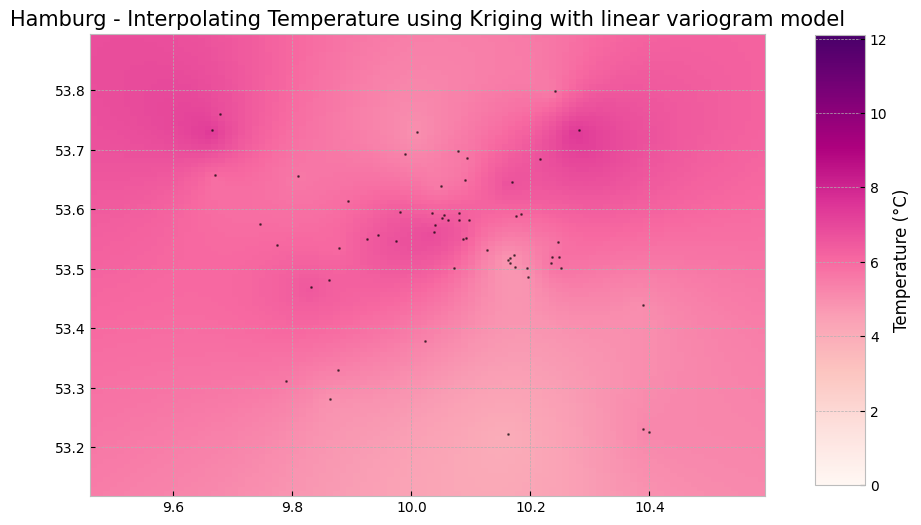

<Figure size 640x480 with 0 Axes>

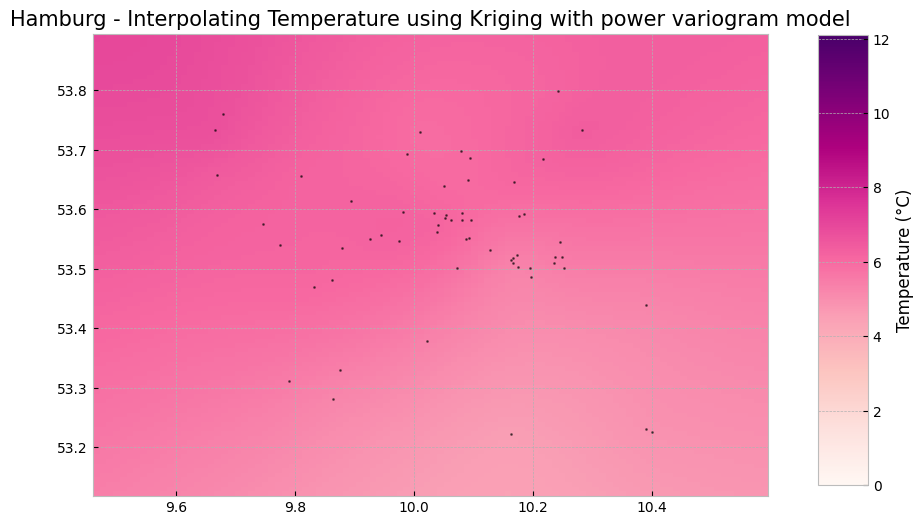

<Figure size 640x480 with 0 Axes>

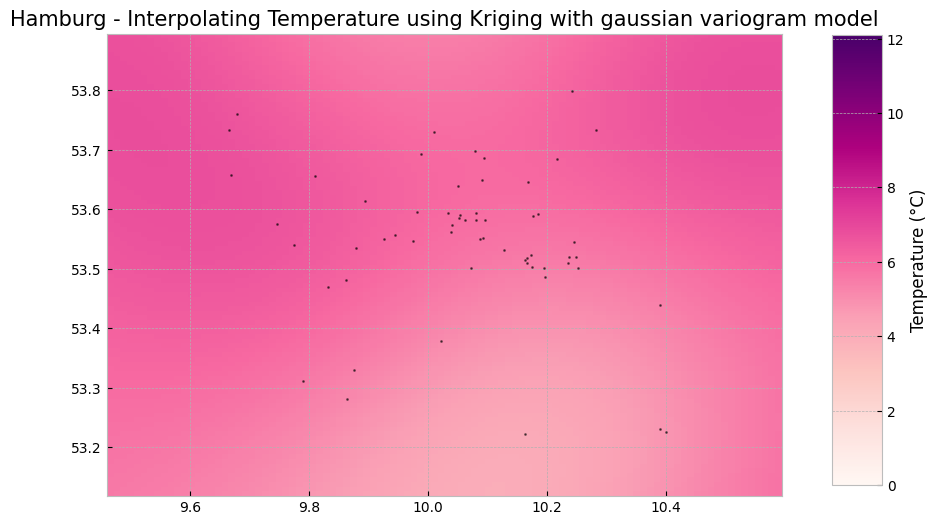

<Figure size 640x480 with 0 Axes>

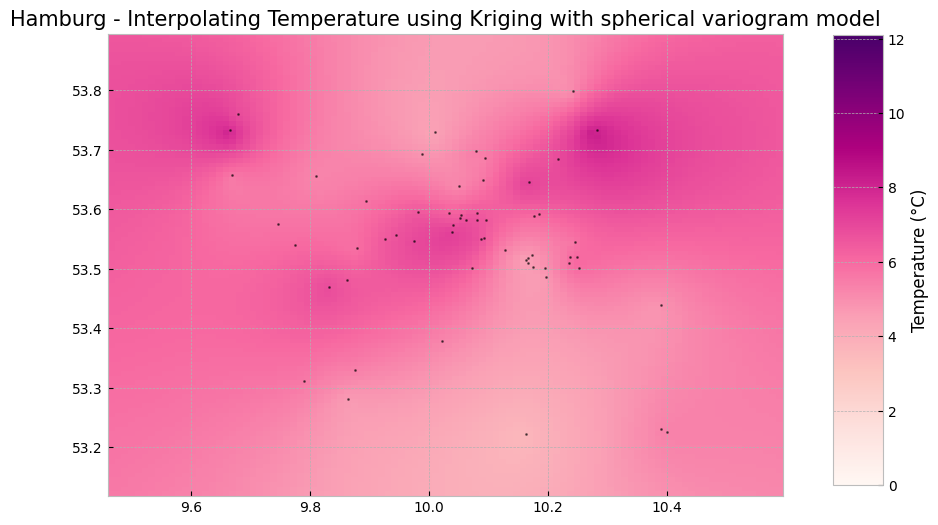

<Figure size 640x480 with 0 Axes>

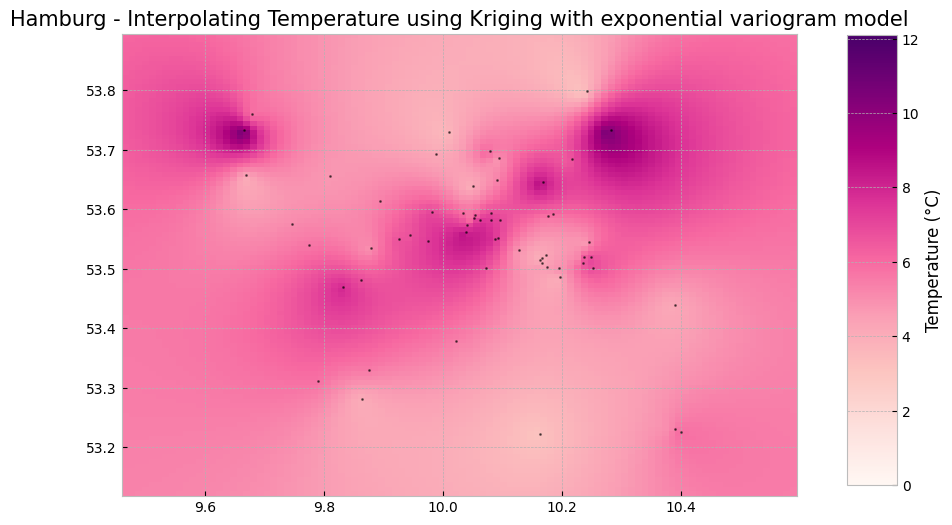

<Figure size 640x480 with 0 Axes>

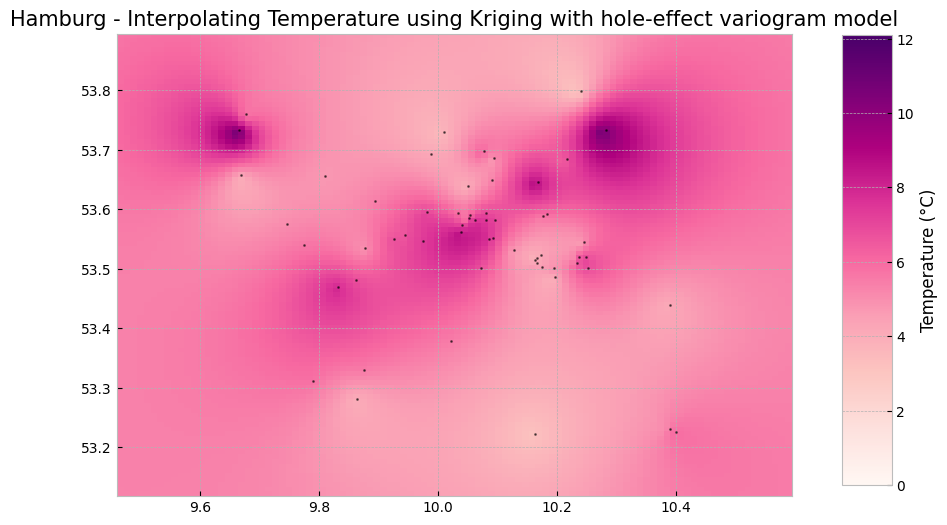

In [122]:
# Interpolate temperature data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_l, raster_pk_l, x_coords_l, y_coords_l, coords_train_l, coords_test_l, value_train_l, value_test_l, Z_pk_krig_l, sigma_squared_p_krig_l, poly_shapely_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear')
raster_pk_extent_p, raster_pk_p, x_coords_p, y_coords_p, coords_train_p, coords_test_p, value_train_p, value_test_p, Z_pk_krig_p, sigma_squared_p_krig_p, poly_shapely_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power')
raster_pk_extent_g, raster_pk_g, x_coords_g, y_coords_g, coords_train_g, coords_test_g, value_train_g, value_test_g, Z_pk_krig_g, sigma_squared_p_krig_g, poly_shapely_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian')
raster_pk_extent, raster_pk_s, x_coords_s, y_coords_s, coords_train_s, coords_test_s, value_train_s, value_test_s, Z_pk_krig_s, sigma_squared_p_krig_s, poly_shapely_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical')
raster_pk_extent_e, raster_pk_e, x_coords_e, y_coords_e, coords_train_e, coords_test_e, value_train_e, value_test_e, Z_pk_krig_e, sigma_squared_p_krig_e, poly_shapely_e = interpolate_ordinary_kriging(krigin_gdf, 'exponential')
raster_pk_extent_h, raster_pk_h, x_coords_h, y_coords_h, coords_train_h, coords_test_h, value_train_h, value_test_h, Z_pk_krig_h, sigma_squared_p_krig_h, poly_shapely_h = interpolate_ordinary_kriging(krigin_gdf, 'hole-effect')


ge5000_clipped = krigin_gdf.clip(poly_shapely_l)

# Plot temperature kriging results
# Reset plot

cmap = plt.cm.YlOrRd  # Choose your desired colormap
vmin = np.min(0)  # Minimum value of the temperature grid
vmax = np.max(krigin_gdf.Temperature)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

plot_kriging_data(raster_pk_l, x_coords_l, y_coords_l, norm, 'linear')
plot_kriging_data(raster_pk_p, x_coords_p, y_coords_p, norm, 'power')
plot_kriging_data(raster_pk_g, x_coords_g, y_coords_g, norm, 'gaussian')
plot_kriging_data(raster_pk_s, x_coords_s, y_coords_s, norm, 'spherical')
plot_kriging_data(raster_pk_e, x_coords_e, y_coords_e, norm, 'exponential')
plot_kriging_data(raster_pk_h, x_coords_h, y_coords_h, norm, 'hole-effect')
# fig.colorbar(mesh, cax=axs[6], label='Temperature (°C)')

plt.show()


## Humidity Interpolation using Ordinary Kriging

In [62]:
# Interpolate humidity data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_hum_l, raster_pk_hum_l, x_coords_hum_l, y_coords_hum_l, coords_train_hum_l, coords_test_hum_l, value_train_hum_l, value_test_hum_l, Z_pk_krig_hum_l, sigma_squared_p_krig_hum_l, poly_shapely_hum_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear', 'Humidity', True)

# Same for power, gaussian, spherical, exponential and hole-effect
raster_pk_extent_hum_p, raster_pk_hum_p, x_coords_hum_p, y_coords_hum_p, coords_train_hum_p, coords_test_hum_p, value_train_hum_p, value_test_hum_p, Z_pk_krig_hum_p, sigma_squared_p_krig_hum_p, poly_shapely_hum_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power', 'Humidity', True)

raster_pk_extent_hum_g, raster_pk_hum_g, x_coords_hum_g, y_coords_hum_g, coords_train_hum_g, coords_test_hum_g, value_train_hum_g, value_test_hum_g, Z_pk_krig_hum_g, sigma_squared_p_krig_hum_g, poly_shapely_hum_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian', 'Humidity', True)

raster_pk_extent_hum_s, raster_pk_hum_s, x_coords_hum_s, y_coords_hum_s, coords_train_hum_s, coords_test_hum_s, value_train_hum_s, value_test_hum_s, Z_pk_krig_hum_s, sigma_squared_p_krig_hum_s, poly_shapely_hum_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical', 'Humidity', True)

raster_pk_extent_hum_e, raster_pk_hum_e, x_coords_hum_e, y_coords_hum_e, coords_train_hum_e, coords_test_hum_e, value_train_hum_e, value_test_hum_e, Z_pk_krig_hum_e, sigma_squared_p_krig_hum_e, poly_shapely_hum_e = interpolate_ordinary_kriging(
    krigin_gdf, 'exponential', 'Humidity', True)

raster_pk_extent_hum_h, raster_pk_hum_h, x_coords_hum_h, y_coords_hum_h, coords_train_hum_h, coords_test_hum_h, value_train_hum_h, value_test_hum_h, Z_pk_krig_hum_h, sigma_squared_p_krig_hum_h, poly_shapely_hum_h = interpolate_ordinary_kriging(
    krigin_gdf, 'hole-effect', 'Humidity', True)


ge5000_clipped = ge5000.clip(poly_shapely_hum_l)

# Plot humidity kriging results
plot_kriging_data(raster_pk_hum_l, x_coords_hum_l,
                  y_coords_hum_l, 'linear', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_p, x_coords_hum_p,
                    y_coords_hum_p, 'power', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_g, x_coords_hum_g,
                    y_coords_hum_g, 'gaussian', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_s, x_coords_hum_s,
                    y_coords_hum_s, 'spherical', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_e, x_coords_hum_e,
                    y_coords_hum_e, 'exponential', 'Humidity', 'Humidity (%)')
plot_kriging_data(raster_pk_hum_h, x_coords_hum_h,
                    y_coords_hum_h, 'hole-effect', 'Humidity', 'Humidity (%)')


PyKrige Kriging out-of-sample r-squared for variogram model linear and target feature Humidity: -7.0
PyKrige Kriging out-of-sample r-squared for variogram model power and target feature Humidity: -7.02
PyKrige Kriging out-of-sample r-squared for variogram model gaussian and target feature Humidity: -7.0
PyKrige Kriging out-of-sample r-squared for variogram model spherical and target feature Humidity: -7.01
PyKrige Kriging out-of-sample r-squared for variogram model exponential and target feature Humidity: -7.02
PyKrige Kriging out-of-sample r-squared for variogram model hole-effect and target feature Humidity: -7.03


NameError: name 'ge5000' is not defined

# ML implementation part

Foundation: TensorFlow with Keras (high level API)

Idea: Have a neural network with all possible sensor locations, stationary and moving, and learn the dependencies between the different sensor locations
- time-series based, so depending on the past improve the prediction quality
- layers (maybe) need to be interconnected, so no simple feed-forward

Model considerations:
- bias:
    - sample bias: (currently) only data from Hamburg area for a certain range of temperature etc. values for a small timeframe, only one climactic zone, close to water, where sensors are located -> placement, representability etc.
    - measurement bias: low quality sensors are less accurate then reference grade equipment, local influences can skew correct readings
    - exclusion bias: currently only a small number of features is measured, but maybe another factor (like soil temperature) has a high influence on the prediction quality and is missing
- loss function: For regression tasks, there are 3 loss functions that are applicalble
    - MSE (Mean Squared Error) -> default for regression problems, if distribution of the target variable is Gaussian, bigger punishment for larger prediction errors
    - MSLE (mean squared logarithmic error) -> It has the effect of relaxing the punishing effect of large differences in large predicted values.

Model candidates:
- RNN (recurrent neural network)
- 

## Keras Specific

- train one layer with static properties (NDVI indexes etc.) and make it non-trainable later

Goals:
model that outputs the temperature on a local scale (city) in a 10 min interval

Inputs:
Sensors:
- stationary sensors with continous data
- moving sensors with infrequent updates at different places

Images???:
- image of weather radar with clouds etc.? -> wetterradar hamburg

Static data:
- indexes (about vegetation, e.g. NDVI...)
- climatic zone (1-7) which gets caslculated via ML classifier


### Model Topology
Sequential model:
- one input and one output tensor for each layer

A Sequential model is not appropriate when:

- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)

Discussion:
Depends on model setup, but I don't think this model is expressive enough to capture the complex interdependencies (but let's try it out)

Functional api:


In [ ]:

# Reference Random Regression Data Set for testing
# generate regression dataset
from sklearn.datasets import make_regression


X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)





In [ ]:
# Keras setup
import tensorflow as tf
from keras.losses import MSE
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()

# define input layer


# define loss function
model.compile(
    loss=MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

# define output layer
model.add(Dense(1, activation='linear'))


: 

: 